In [1]:
# Regular EDA and plotting libraries
import numpy as np # np is short for numpy
import pandas as pd # pandas is so commonly used, it's shortened to pd
import matplotlib.pyplot as plt
import seaborn as sns # seaborn gets shortened to sns

# We want our plots to appear in the notebook
%matplotlib inline 

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [2]:
def read_dataset(template, start_idx, end_idx):
    frames = [ pd.read_json(f) for f in [template.format(i) for i in range(start_idx, end_idx+1)] ]
    return pd.concat(frames, ignore_index = True)

df = read_dataset("datasets/dataset_initial/dataset_{:02}.json", 0, 17)
df.drop(['patch_version', 'map_crc', 'active_smokes', 'active_molotovs', 'previous_kills', 'planted_bomb'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87132 entries, 0 to 87131
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   map                     87132 non-null  object 
 1   current_score           87132 non-null  object 
 2   round_status            87132 non-null  object 
 3   round_status_time_left  87132 non-null  float64
 4   alive_players           87132 non-null  object 
 5   round_winner            87132 non-null  object 
dtypes: float64(1), object(5)
memory usage: 4.0+ MB


In [3]:
def get_attr(ds, team, attr=None):
    team_players = map(lambda players: filter(lambda p: p["team"] == team, players), ds['alive_players'])
    if attr:
        team_players = map(lambda players: map(lambda p: p[attr], players), team_players)
    
    return list(map(lambda p: list(p), team_players))

df['alive_players_t']  = list(map(len, get_attr(df, "Terrorist")))
df['alive_players_ct'] = list(map(len, get_attr(df, "CT")))
df['health_ct']        = list(map(sum, get_attr(df, "CT", "health")))
df['health_t']         = list(map(sum, get_attr(df, "Terrorist", "health")))
df['money_ct']         = list(map(sum, get_attr(df, "CT", "money")))
df['money_t']          = list(map(sum, get_attr(df, "Terrorist", "money")))

df.round_winner = df.round_winner.map(lambda team: 0 if team == "CT" else 1)

df['score_ct'] = df.current_score.map(lambda score: score[0])
df['score_t'] = df.current_score.map(lambda score: score[1])

#df.map = df.map.astype('category')
#df.round_status = df.round_status.astype('category')
df = pd.get_dummies(df, columns=["map", "round_status"], prefix=["map", "status"])

df.drop(['alive_players', 'current_score'], axis=1, inplace=True)

for i in df.loc[lambda df: df.alive_players_t == 6].index:
    df.drop(df.index[i], inplace=True)
df = df.loc[lambda df: df.alive_players_t != 6]

df.rename(columns = {'round_status_time_left':'time_left'}, inplace = True) 

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87129 entries, 0 to 87131
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   time_left           87129 non-null  float64
 1   round_winner        87129 non-null  int64  
 2   alive_players_t     87129 non-null  int64  
 3   alive_players_ct    87129 non-null  int64  
 4   health_ct           87129 non-null  int64  
 5   health_t            87129 non-null  int64  
 6   money_ct            87129 non-null  int64  
 7   money_t             87129 non-null  int64  
 8   score_ct            87129 non-null  int64  
 9   score_t             87129 non-null  int64  
 10  map_de_cache        87129 non-null  uint8  
 11  map_de_dust2        87129 non-null  uint8  
 12  map_de_inferno      87129 non-null  uint8  
 13  map_de_mirage       87129 non-null  uint8  
 14  map_de_nuke         87129 non-null  uint8  
 15  map_de_overpass     87129 non-null  uint8  
 16  map_

In [4]:
df.describe()

,time_left,round_winner,alive_players_t,alive_players_ct,health_ct,health_t,money_ct,money_t,score_ct,score_t,...,map_de_dust2,map_de_inferno,map_de_mirage,map_de_nuke,map_de_overpass,map_de_train,map_de_vertigo,status_BombPlanted,status_FreezeTime,status_Normal
count,87129.000000,87129.000000,87129.000000,87129.000000,87129.000000,87129.000000,87129.000000,87129.000000,87129.000000,87129.000000,...,87129.000000,87129.000000,87129.000000,87129.000000,87129.000000,87129.000000,87129.000000,87129.000000,87129.000000,87129.000000
mean,55.676240,0.510978,4.247254,4.259122,410.274822,400.528423,10028.513469,11502.732156,6.836771,6.938838,...,0.176933,0.205879,0.147253,0.135787,0.137279,0.098980,0.096225,0.113016,0.263827,0.623156
std,36.552753,0.499882,1.238835,1.213848,133.167475,140.858780,11487.279061,12482.307046,4.884438,4.830961,...,0.381614,0.404345,0.354360,0.342564,0.344144,0.298636,0.294901,0.316615,0.440709,0.484598
min,0.007812,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.953125,0.000000,4.000000,4.000000,343.000000,314.000000,1350.000000,1650.000000,3.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,54.804688,1.000000,5.000000,5.000000,500.000000,500.000000,5800.000000,7350.000000,6.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,94.843750,1.000000,5.000000,5.000000,500.000000,500.000000,14900.000000,18350.000000,10.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,115.000000,1.000000,5.000000,5.000000,500.000000,500.000000,80000.000000,80000.000000,32.000000,33.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


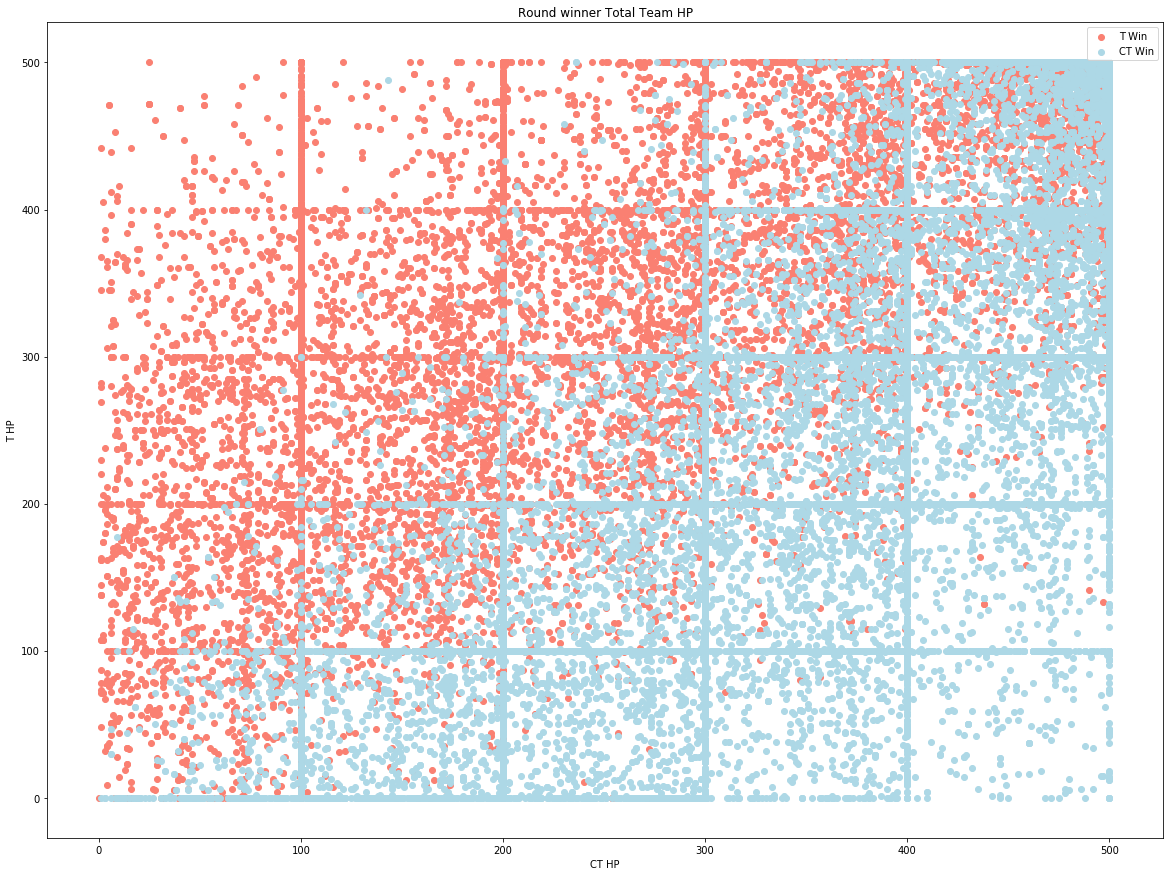

In [5]:
# Create figure
plt.figure(figsize=(20,15))

# Start with T wins
plt.scatter(df.health_ct[df.round_winner==1], 
            df.health_t[df.round_winner==1], 
            c="salmon") # define it as a scatter figure

# Now for CT wins, we want them on the same plot, so we call plt again
plt.scatter(df.health_ct[df.round_winner==0], 
            df.health_t[df.round_winner==0], 
            c="lightblue") # axis always come as (x, y)

# Add some helpful info
plt.title("Round winner Total Team HP")
plt.xlabel("CT HP")
plt.legend(["T Win", "CT Win"])
plt.ylabel("T HP");

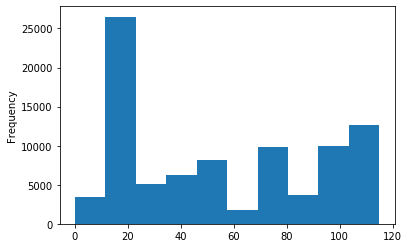

In [6]:
# Histograms are a great way to check the distribution of a variable
df.time_left.plot.hist()

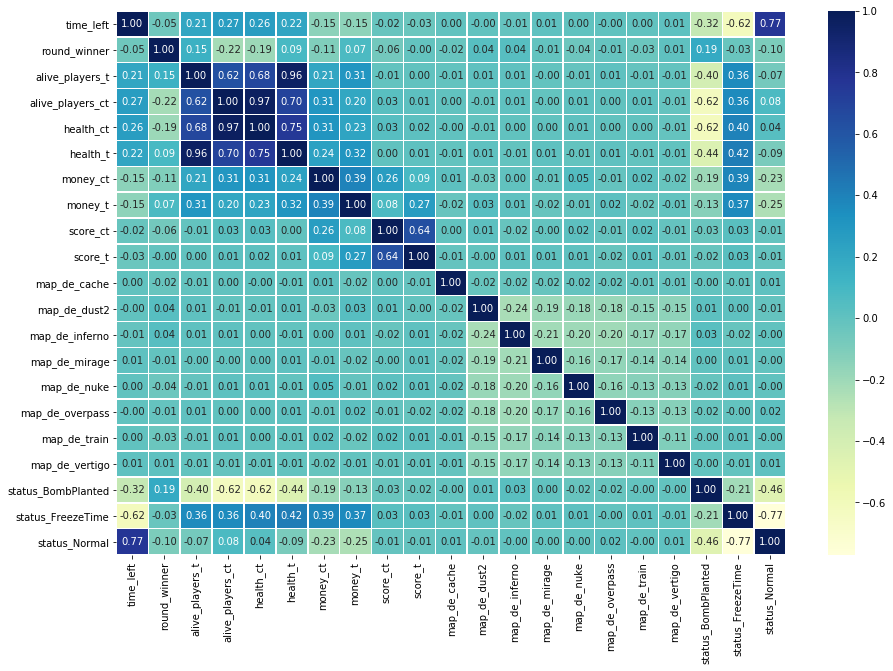

In [7]:
# Find the correlation between our independent variables
corr_matrix = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu")

In [8]:
# Everything except target variable
X = df.drop("round_winner", axis=1)

# Target variable
y = df.round_winner.values

In [9]:
#train, test = train_test_split(df, test_size=0.1)
#train, val = train_test_split(train, test_size=0.2)
#print(len(train), 'train examples')
#print(len(test), 'test examples')
# Random seed for reproducibility
np.random.seed(42)

# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, # independent variables 
                                                    y, # dependent variable
                                                    test_size = 0.2) # percentage of data to use for test set

In [10]:
# Put models in a dictionary
models = {"KNN": KNeighborsClassifier(),
          "Logistic Regression": LogisticRegression(), 
          "Random Forest": RandomForestClassifier()}

# Create function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [11]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

{'KNN': 0.685871685986457,
 'Logistic Regression': 0.6444393435096981,
 'Random Forest': 0.7897968552737289}